# Analisis Masalah


 Travelling Salesman Problem merupakan masalah diskrit yang relatif sering dibahas dalam permasalahan komputasi. Pada permasalahan TSP, diberikan daftar koordinat kota, lalu diminta untuk menemukan rute terpendek, yang mana harus mendatangi seluruh kota dan kembali ke kota asal. TSP tergolong NP-Hard problem dalam optimisasi kombinatorial. 

Pada Tugas Mandiri 1 mata kuliah Kecerdasan Kelompok 2018, mahasiswa diminta untuk menyelesaikan dua set permasalahan TSP, yaitu TSP dengan **16 nodes** dan **96 nodes** menggunakan algoritma ** Ant System**.  

Pada Ant System, terdapat beberapa parameter yang perlu dievaluasi untuk dapat menemukan rute paling optimal (ditandai dengan didapatkannya rute dengan jarak terkecil yang memungkinkan). _Trade-off_ dalam pengaturan beberapa parameter ini sangat mempengaruhi terhadap kualitas solusi yang diberikan oleh algoritma. Parameter-parameter tersebut diantaranya:


*   $Q$ : Konstanta yang digunakan sebagai pembilang dalam menentukan kuantitas pheromon
*   $\rho$ : Penguapan pheromon
* $\alpha$ : Parameter yang mengatur seberapa pentingnya jejak pheromon digunakan dalam membangun solusi
* $\beta$ : Parameter yang mengatur seberapa pentingnya visibility ($\frac{1}{distance}$) digunakan dalam membangun solusi

# Desain Program

Dalam membangun solusi menggunakan Ant System, penulis mengikuti algoritma yang terdapat pada buku _Swarm Intelligence_, Suyanto, dan algoritma Ant System pada slide perkuliahan Kecerdasan Kolektif 2018. 

Pencarian nilai paling optimum dari parameter di atas digunakan dengan beberapa percobaan. Berdasarkan percobaan yang telah dilakukan, nilai parameter yang paling tepat untuk menghasilkan solusi terbaik adalah sebagai berikut:
* $Q$ : 0.2
* $\rho$ : 0.2
* $\alpha$ : 11
* $\beta$ : 14

menggunakan iterasi sebanyak **200 iterasi **dengan **50 individu semut**.

Program di-_running_ sebanyak 30 kali untuk mendapatkan nilai rata-rata performansi sistem yang dibuat. Hasil program **96 nodes** tercantum pada bagian akhir di dalam bagian 3. _Sourcecode_. Sedangkan hasil program 16 nodes tercantum pada bagian akhir bagian 3._Sourcecode_ pada file berbeda (_Laporan Tugas 1 Swarm 16 Nodes.pdf_)

# Source Code, 

In [1]:
# Author: Vebby Clarissa
# September 2018

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

In [2]:
def plotNodes(nodelist,route):
    """
    :param nodelist: list node dengan 3 kolom (no, x, y)
    :param route   : rute yang akan di plot
    :return        : visualisasi tour
    """
    x = []
    y = []
    for i in range(len(route)):
        x.append(nodelist[route[i]][1])
        y.append(nodelist[route[i]][2])
    plt.plot(x,y,'bo',linestyle='-')
    plt.title("Best Generated Route",loc='center',fontweight='bold')
    plt.show()

In [3]:
def generate_matriks_jarak (nodelist):
    """
    :param nodelist: list node dengan 3 kolom (no, x y)
    :return        : matriks jarak [16x16] yang berisi jarak antar node satu dengan lainnya
                     dengan asumsi node full connected
    """
    distances = np.zeros((len(nodelist),len(nodelist)))
    for i in range (len(nodelist)):
        for j in range (len(nodelist)):
            distances[i][j] = math.sqrt((nodelist[i][1]-nodelist[j][1])**2 + (nodelist[i][2]-nodelist[j][2])**2)          
    return (distances)

In [4]:
def generate_start_nodes (individu,n_kota):
    """
    :param individu:(int) jumlah semut
    :param n_kota  :(int) jumlah kota
    :return        : tabulist yang masih berisi start (dan end) node untuk semua individu semut
    """
    start_nodes= []
    for i in range (individu):        
        start_nodes.append([0 for i in range(n_kota+1)])
        start_nodes[-1][0] = random.randint(0,(n_kota-1))
        start_nodes[-1][-1] = start_nodes[-1][0]
    return start_nodes

In [5]:
def evaluate_best_city (kota_sekarang, matriks_jarak ,tau, tabulist, alpha, beta):
    """
    Mengevaluasi kota terbaik yang memungkinkan berdasarkan probabilitas dan tabulist
    :param kota_sekarang: (int 0..15) 
    :param tabulist     : (int[0..15]) merupakan kota yang sudah pernah dikunjungi oleh semut
    :param tau          : (list) intensitas pheromon pada 
    :param matriks_jarak: (matriks[16][16]) matriks yang berisi jarak antar kota
    :return             : kota dengan probabilitas tertinggi
    """
    probability = [0] * np.size(matriks_jarak[1])
    allowed = []
    allowed[:] = [x for x in range(np.size(matriks_jarak[1])) if x not in tabulist]
    p = 0
    for i in allowed:
        visibility = 1/matriks_jarak[kota_sekarang][i]
        p += (tau[kota_sekarang][i]**alpha)*(visibility**beta)
    for i in allowed:
        visibility = 1/matriks_jarak[kota_sekarang][i]
        probability[i] = (tau[kota_sekarang][i]**alpha)*(visibility**beta)/p
    tmp = max(probability)
    return probability.index(tmp)

In [6]:
def update_tau(individu, tau, tabulists, L, evaporation_coeff, Q,n_kota):
    """
    :param evaporation: koefisien evaporation
    :param tau        : matriks tau seukuran kota x kota
    :param L          : matriks/array[1x16] yang mengandung informasi jarak tour yang
                        dihasilkan oleh satu semut
    :param delta_tau  : matriks seukuran kota x kota
    :return           : tau yang baru
    """
    for i in range (individu):
        for j in range (n_kota):
            delta_tau = Q/L[i]
            tau[tabulists[i][j],tabulists[i][j+1]] = evaporation_coeff * tau[tabulists[i][j],tabulists[i][j+1]] + delta_tau
    return (tau)

In [7]:
def hitung_jarak_1_rute(single_solution,matriks_jarak):
    """
    :param single_solution: Sebuah tabulist dari seekor semut (1 solusi) [0..16]
    :param matriks_jarak  : matriks jarak antar node
    :return               : Total jarak yang dihasilkan solusi tersebut
    """
    jarak = 0
    for i in range (len(single_solution)-1):
        jarak += matriks_jarak[single_solution[i]][single_solution[i+1]]       
    return (jarak)

In [8]:
def compute_shortest_distances(tabulists, matriks_jarak):
    """
    :param tabulists: Tabulist sejumlah individu x banyak kota
    :return         : tuple (jarak terkecil yang di temukan (float)
                             rute dengan jarak terkecil (list),
                             list jarak (L)(list)
                             rata2 jarak yang ditemukan (float))
                    :>>>(min_dist,route,L,rerata)
    """
    distances = []
    distances = [0] * len(tabulists)
    for i in range(0,len(tabulists)):
        distances[i] = hitung_jarak_1_rute(tabulists[i],matriks_jarak)
    L = distances
    L = L- 0.97*min(L)
    return (min(distances) , tabulists[distances.index(min(distances))] , L, np.mean(distances))

=========================== RUN:  1 ====================================
Route     :  [0, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 64, 95, 93, 94, 92, 91, 76, 75, 72, 71, 70, 73, 74, 77, 87, 88, 89, 86, 85, 84, 83, 81, 80, 82, 90, 79, 78, 44, 43, 32, 33, 34, 10, 45, 46, 47, 53, 57, 24, 23, 22, 25, 27, 26, 21, 20, 18, 17, 16, 19, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 2, 1, 28, 0]
Best Route:  532.341257057


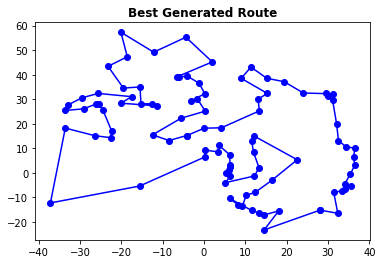

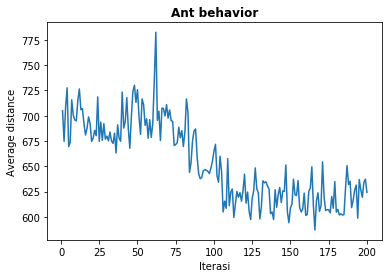

Running time so far:  183.76 second
======================== END OF RUN:  1 ================================


=========================== RUN:  2 ====================================
Route     :  [31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 47, 46, 45, 44, 43, 32, 33, 34, 37, 36, 35, 10, 49, 51, 52, 54, 50, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 65, 66, 67, 63, 62, 61, 60, 58, 59, 57, 53, 48, 42, 41, 40, 39, 38, 78, 79, 0, 31]
Best Route:  560.622111555


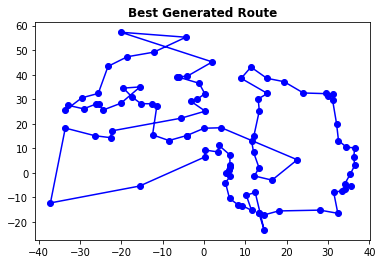

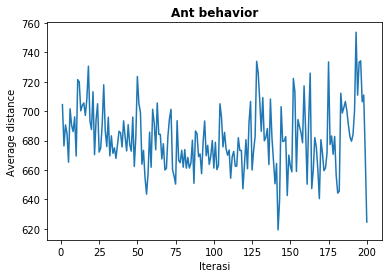

Running time so far:  366.60 second
======================== END OF RUN:  2 ================================


=========================== RUN:  3 ====================================
Route     :  [34, 33, 32, 43, 44, 10, 45, 46, 47, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 27, 26, 25, 21, 22, 23, 24, 20, 18, 19, 17, 16, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 1, 2, 28, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 78, 79, 0, 34]
Best Route:  538.987614631


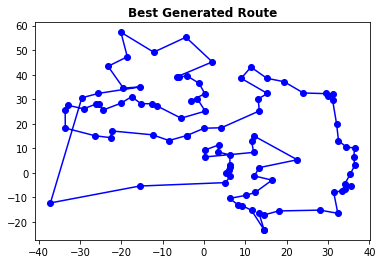

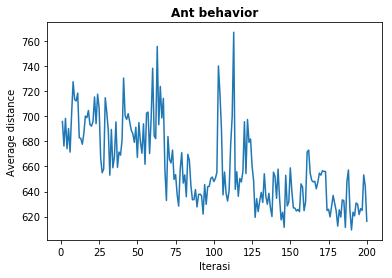

Running time so far:  550.04 second
======================== END OF RUN:  3 ================================


=========================== RUN:  4 ====================================
Route     :  [10, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 47, 46, 45, 49, 51, 52, 54, 50, 48, 42, 41, 40, 39, 38, 78, 79, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 65, 66, 67, 63, 62, 61, 60, 59, 58, 57, 53, 55, 56, 68, 69, 81, 80, 82, 0, 10]
Best Route:  558.61680267


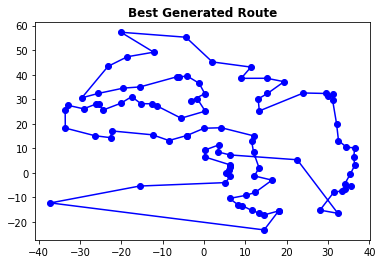

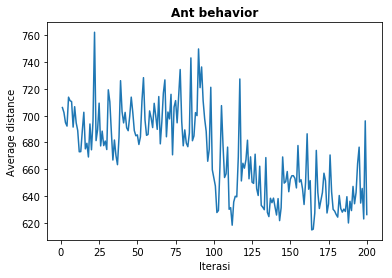

Running time so far:  734.45 second
======================== END OF RUN:  4 ================================


=========================== RUN:  5 ====================================
Route     :  [10, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 17, 20, 18, 21, 25, 27, 26, 22, 23, 24, 47, 46, 45, 49, 51, 52, 54, 50, 48, 42, 41, 40, 39, 38, 78, 68, 69, 56, 55, 57, 53, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 74, 72, 71, 70, 73, 83, 84, 85, 86, 88, 89, 87, 77, 91, 92, 93, 95, 64, 94, 81, 80, 82, 90, 58, 79, 0, 10]
Best Route:  559.424889966


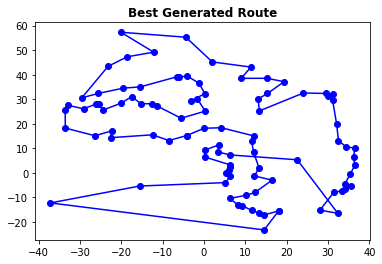

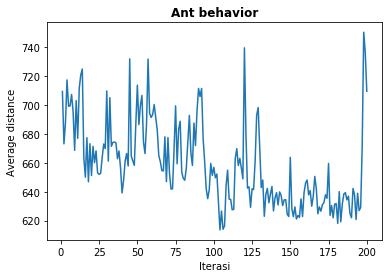

Running time so far:  917.90 second
======================== END OF RUN:  5 ================================


=========================== RUN:  6 ====================================
Route     :  [29, 30, 31, 35, 36, 37, 34, 33, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 64, 27, 26, 25, 21, 22, 23, 24, 47, 46, 45, 44, 43, 32, 10, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 53, 57, 70, 71, 72, 74, 73, 83, 84, 85, 86, 88, 89, 87, 77, 91, 92, 93, 95, 94, 75, 76, 90, 82, 80, 81, 79, 78, 0, 29]
Best Route:  583.13971552


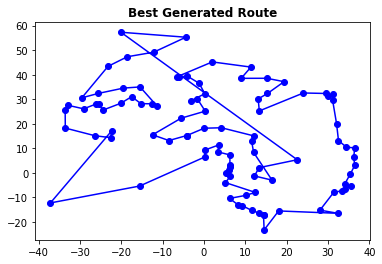

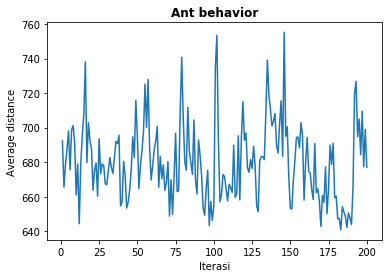

Running time so far:  1101.07 second
======================== END OF RUN:  6 ================================


=========================== RUN:  7 ====================================
Route     :  [31, 30, 29, 28, 35, 36, 37, 34, 33, 32, 43, 44, 45, 46, 47, 24, 23, 22, 25, 21, 20, 18, 17, 16, 19, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 1, 2, 10, 53, 57, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 64, 27, 26, 95, 93, 94, 92, 91, 76, 75, 72, 71, 70, 73, 74, 77, 87, 85, 84, 83, 86, 88, 89, 90, 82, 80, 81, 78, 79, 50, 54, 51, 52, 49, 48, 42, 41, 40, 39, 38, 0, 31]
Best Route:  554.839922411


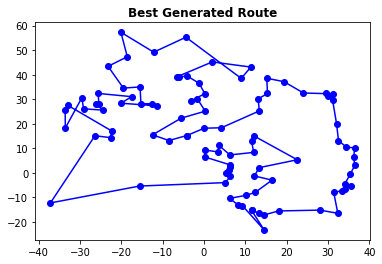

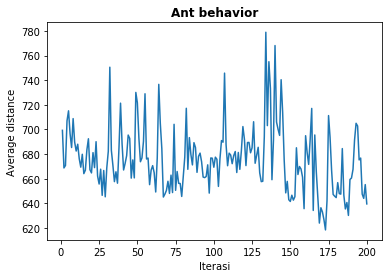

Running time so far:  1285.33 second
======================== END OF RUN:  7 ================================


=========================== RUN:  8 ====================================
Route     :  [43, 44, 42, 48, 41, 40, 39, 38, 37, 34, 33, 32, 10, 45, 46, 47, 24, 23, 22, 25, 21, 20, 18, 19, 17, 16, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 1, 2, 28, 29, 30, 31, 35, 36, 78, 79, 69, 68, 56, 55, 57, 53, 52, 54, 50, 51, 49, 70, 71, 72, 74, 73, 83, 84, 85, 86, 88, 89, 90, 82, 80, 81, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 77, 87, 91, 92, 93, 95, 64, 27, 26, 94, 0, 43]
Best Route:  546.650375005


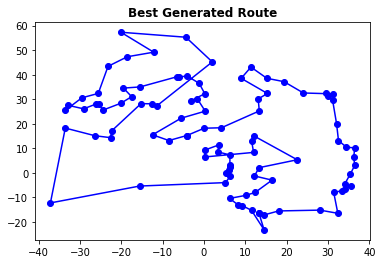

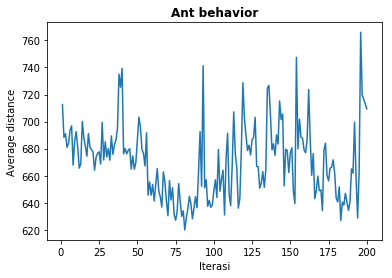

Running time so far:  1468.60 second
======================== END OF RUN:  8 ================================


=========================== RUN:  9 ====================================
Route     :  [52, 51, 49, 45, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 58, 60, 62, 61, 59, 63, 65, 66, 67, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 10, 46, 47, 54, 50, 48, 42, 41, 40, 39, 38, 78, 79, 0, 52]
Best Route:  560.501405677


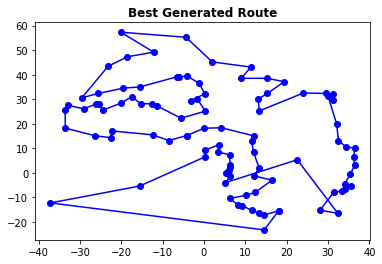

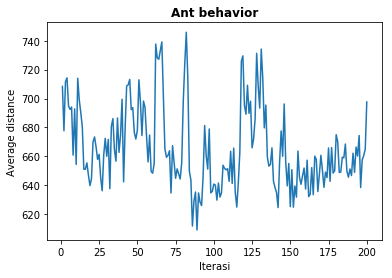

Running time so far:  1652.14 second
======================== END OF RUN:  9 ================================


=========================== RUN:  10 ====================================
Route     :  [28, 29, 30, 31, 35, 36, 37, 34, 33, 32, 43, 44, 45, 46, 47, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 75, 76, 77, 87, 91, 92, 93, 95, 64, 27, 26, 25, 21, 22, 23, 24, 20, 18, 19, 17, 16, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 1, 2, 10, 49, 51, 54, 50, 52, 48, 42, 41, 40, 39, 38, 78, 79, 72, 71, 70, 58, 60, 61, 62, 63, 65, 66, 67, 94, 59, 0, 28]
Best Route:  581.219681919


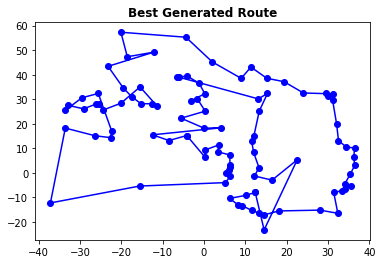

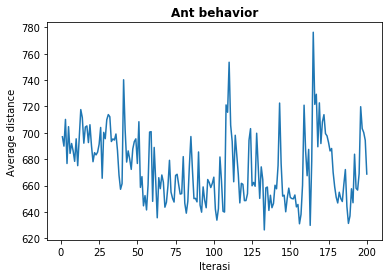

Running time so far:  1835.61 second
======================== END OF RUN:  10 ================================


=========================== RUN:  11 ====================================
Route     :  [1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 74, 72, 71, 70, 73, 83, 84, 85, 86, 88, 89, 87, 77, 91, 92, 93, 95, 64, 94, 81, 80, 82, 90, 79, 78, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 46, 47, 45, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 10, 0, 1]
Best Route:  564.95909181


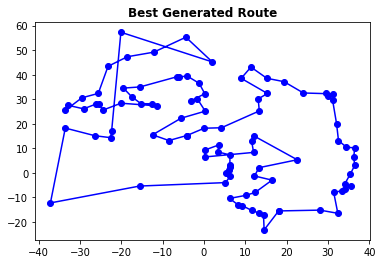

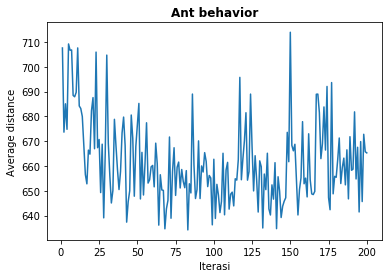

Running time so far:  2018.53 second
======================== END OF RUN:  11 ================================


=========================== RUN:  12 ====================================
Route     :  [78, 79, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 74, 72, 71, 70, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 77, 87, 91, 92, 94, 93, 95, 64, 27, 26, 25, 21, 22, 23, 24, 47, 46, 45, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 53, 57, 55, 56, 68, 54, 50, 48, 42, 41, 40, 39, 38, 49, 51, 52, 10, 0, 78]
Best Route:  567.566885062


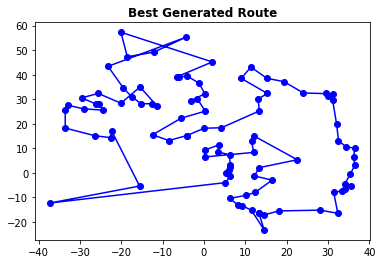

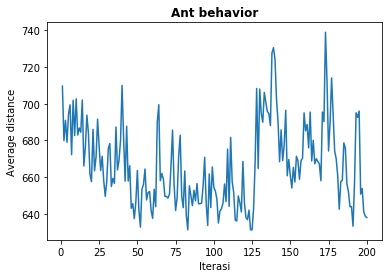

Running time so far:  2202.07 second
======================== END OF RUN:  12 ================================


=========================== RUN:  13 ====================================
Route     :  [79, 78, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 75, 76, 77, 87, 91, 92, 93, 95, 94, 67, 66, 65, 63, 62, 61, 60, 59, 58, 24, 23, 22, 21, 25, 27, 26, 64, 20, 18, 17, 16, 19, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 1, 2, 28, 29, 30, 31, 35, 36, 37, 34, 33, 32, 43, 44, 45, 46, 47, 10, 0, 79]
Best Route:  559.795411408


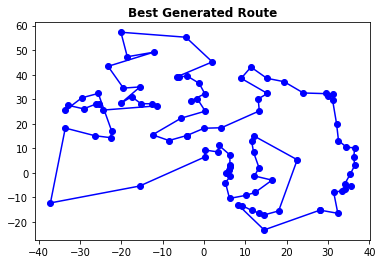

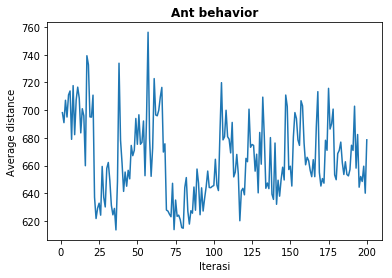

Running time so far:  2385.14 second
======================== END OF RUN:  13 ================================


=========================== RUN:  14 ====================================
Route     :  [34, 33, 32, 43, 44, 45, 49, 51, 52, 54, 50, 48, 42, 41, 40, 39, 38, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 22, 23, 24, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 27, 26, 47, 46, 10, 78, 79, 0, 34]
Best Route:  543.363325587


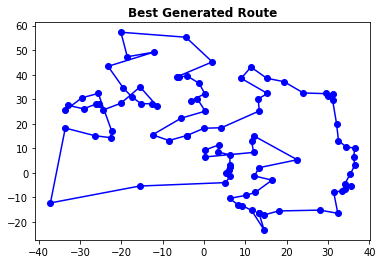

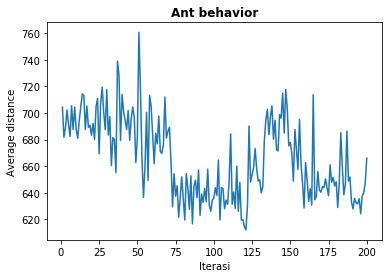

Running time so far:  2568.54 second
======================== END OF RUN:  14 ================================


=========================== RUN:  15 ====================================
Route     :  [10, 46, 47, 45, 49, 51, 52, 54, 50, 48, 42, 41, 40, 39, 38, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 74, 72, 71, 70, 73, 83, 84, 85, 87, 77, 91, 92, 93, 95, 64, 94, 81, 80, 82, 90, 89, 88, 86, 78, 79, 34, 33, 32, 43, 44, 0, 10]
Best Route:  552.319729742


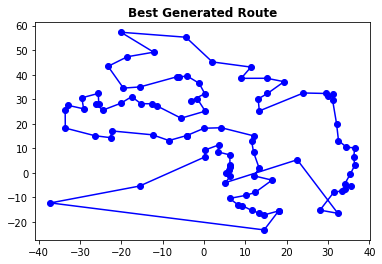

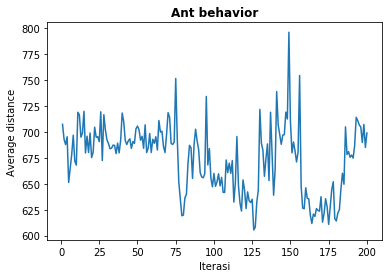

Running time so far:  2752.71 second
======================== END OF RUN:  15 ================================


=========================== RUN:  16 ====================================
Route     :  [33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 64, 65, 66, 67, 63, 62, 61, 60, 59, 58, 57, 53, 47, 46, 45, 44, 43, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 75, 76, 77, 87, 91, 92, 93, 95, 94, 23, 22, 24, 10, 32, 38, 78, 79, 0, 33]
Best Route:  581.161452947


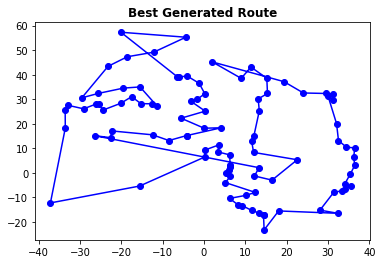

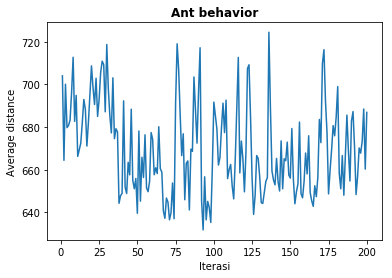

Running time so far:  2936.44 second
======================== END OF RUN:  16 ================================


=========================== RUN:  17 ====================================
Route     :  [35, 36, 37, 34, 33, 32, 43, 44, 45, 46, 47, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 27, 26, 25, 21, 22, 23, 24, 20, 18, 17, 16, 19, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 1, 2, 10, 49, 51, 52, 54, 50, 48, 42, 41, 40, 39, 38, 78, 79, 31, 30, 29, 28, 0, 35]
Best Route:  551.298953542


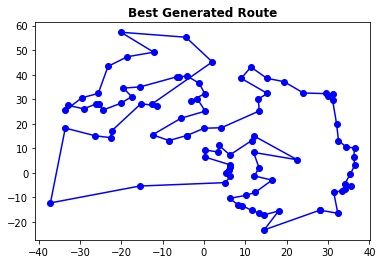

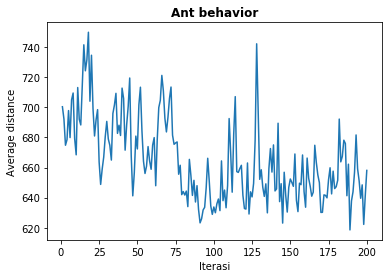

Running time so far:  3119.98 second
======================== END OF RUN:  17 ================================


=========================== RUN:  18 ====================================
Route     :  [41, 40, 39, 38, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 74, 72, 71, 70, 73, 83, 84, 85, 86, 88, 89, 87, 77, 91, 92, 93, 95, 64, 94, 81, 80, 82, 90, 79, 78, 50, 54, 51, 52, 49, 48, 42, 43, 44, 45, 46, 47, 10, 32, 33, 34, 0, 41]
Best Route:  566.205142599


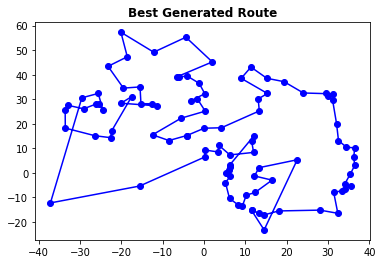

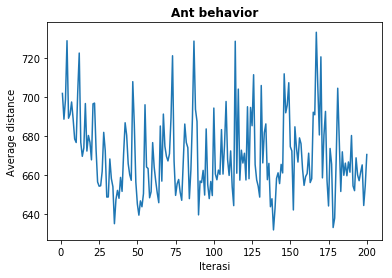

Running time so far:  3303.04 second
======================== END OF RUN:  18 ================================


=========================== RUN:  19 ====================================
Route     :  [38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 45, 46, 47, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 76, 75, 91, 92, 93, 67, 66, 65, 63, 62, 61, 60, 59, 58, 70, 71, 72, 77, 87, 94, 95, 64, 27, 26, 25, 21, 20, 18, 19, 17, 16, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 1, 2, 28, 29, 30, 31, 35, 36, 37, 34, 33, 32, 43, 44, 10, 24, 23, 22, 79, 78, 0, 38]
Best Route:  558.61680267


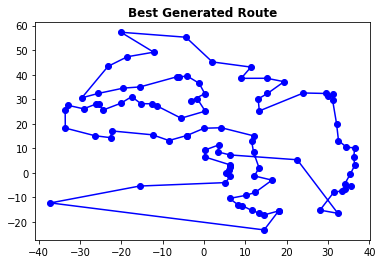

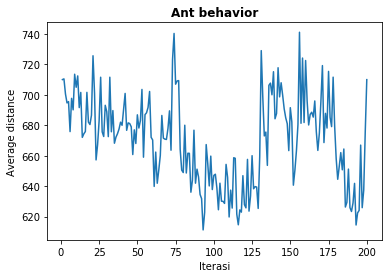

Running time so far:  3486.58 second
======================== END OF RUN:  19 ================================


=========================== RUN:  20 ====================================
Route     :  [36, 35, 31, 30, 29, 28, 33, 34, 37, 38, 39, 40, 41, 42, 48, 49, 51, 54, 50, 52, 46, 47, 45, 44, 43, 32, 10, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 74, 72, 71, 70, 73, 83, 84, 85, 86, 88, 89, 87, 77, 91, 92, 93, 95, 64, 94, 81, 80, 82, 90, 79, 78, 0, 36]
Best Route:  560.482811049


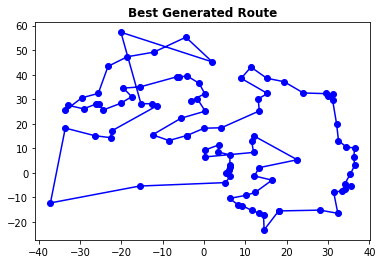

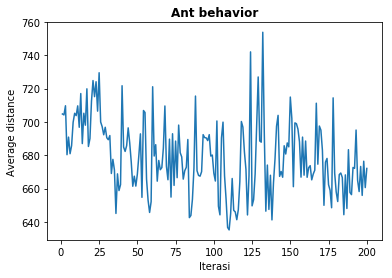

Running time so far:  3670.66 second
======================== END OF RUN:  20 ================================


=========================== RUN:  21 ====================================
Route     :  [33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 76, 75, 72, 71, 70, 58, 59, 61, 60, 62, 63, 65, 66, 67, 64, 95, 94, 92, 93, 91, 77, 87, 78, 79, 38, 39, 40, 41, 42, 48, 49, 51, 52, 50, 54, 45, 44, 43, 32, 10, 46, 47, 0, 33]
Best Route:  558.61680267


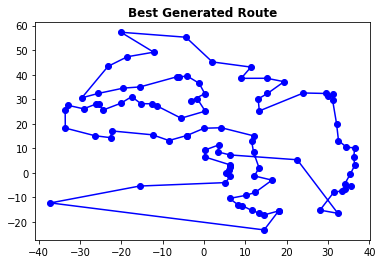

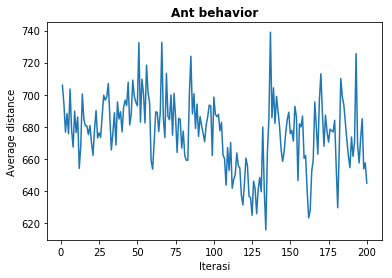

Running time so far:  3854.21 second
======================== END OF RUN:  21 ================================


=========================== RUN:  22 ====================================
Route     :  [1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 58, 59, 61, 60, 62, 63, 65, 66, 67, 64, 95, 94, 92, 93, 91, 76, 75, 77, 87, 79, 78, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 45, 46, 47, 10, 32, 43, 44, 33, 34, 37, 36, 35, 31, 30, 29, 28, 0, 1]
Best Route:  543.363325587


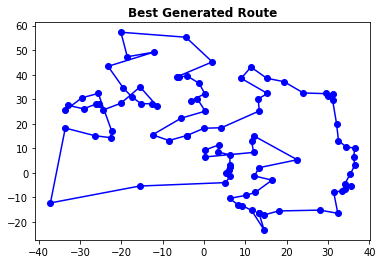

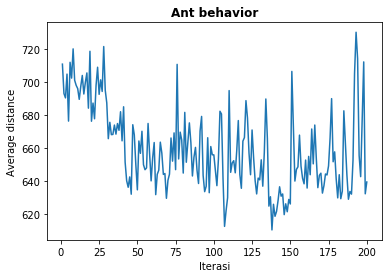

Running time so far:  4036.82 second
======================== END OF RUN:  22 ================================


=========================== RUN:  23 ====================================
Route     :  [43, 44, 32, 10, 45, 46, 47, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 27, 26, 25, 21, 22, 23, 24, 20, 18, 17, 19, 16, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 1, 2, 28, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 78, 79, 34, 33, 0, 43]
Best Route:  551.076889071


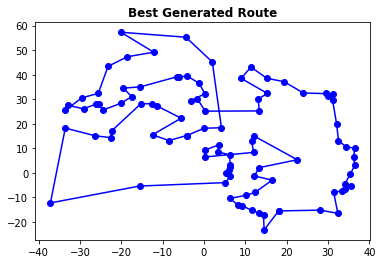

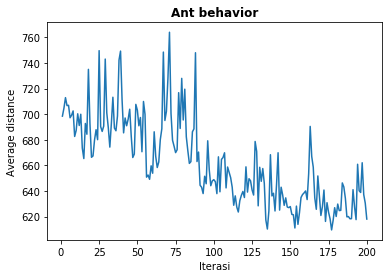

Running time so far:  4220.54 second
======================== END OF RUN:  23 ================================


=========================== RUN:  24 ====================================
Route     :  [1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 58, 59, 61, 60, 62, 63, 65, 66, 67, 75, 76, 74, 72, 71, 70, 73, 83, 84, 85, 86, 88, 89, 87, 77, 91, 92, 93, 95, 64, 94, 81, 80, 82, 90, 79, 78, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 45, 46, 47, 10, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 0, 1]
Best Route:  567.943284475


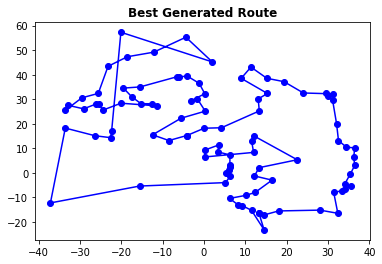

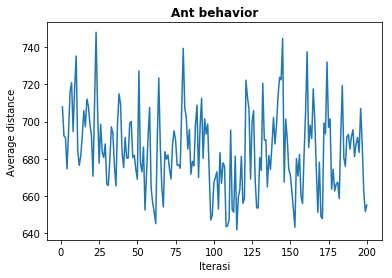

Running time so far:  4404.06 second
======================== END OF RUN:  24 ================================


=========================== RUN:  25 ====================================
Route     :  [8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 47, 46, 45, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 10, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 65, 66, 67, 63, 62, 61, 60, 59, 58, 57, 53, 78, 79, 0, 8]
Best Route:  557.268246667


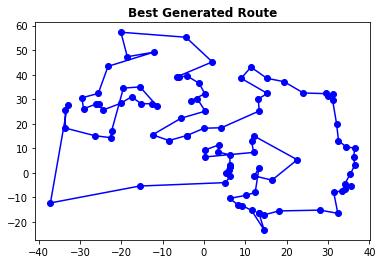

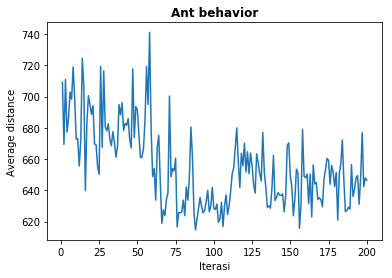

Running time so far:  4587.67 second
======================== END OF RUN:  25 ================================


=========================== RUN:  26 ====================================
Route     :  [36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 58, 59, 61, 60, 62, 63, 65, 66, 67, 64, 95, 93, 94, 92, 91, 76, 75, 77, 87, 78, 79, 50, 54, 52, 51, 49, 48, 42, 41, 40, 39, 38, 43, 44, 32, 33, 34, 37, 46, 47, 45, 10, 0, 36]
Best Route:  558.781726069


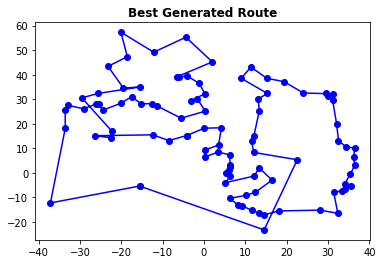

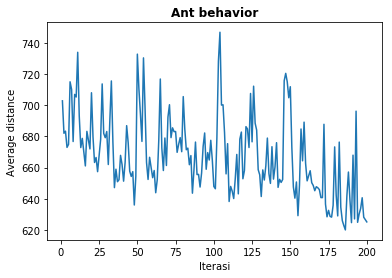

Running time so far:  4771.06 second
======================== END OF RUN:  26 ================================


=========================== RUN:  27 ====================================
Route     :  [3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 22, 23, 24, 59, 61, 60, 62, 63, 65, 66, 67, 64, 27, 26, 95, 93, 94, 92, 91, 76, 75, 73, 74, 72, 71, 70, 58, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 77, 87, 79, 78, 38, 39, 40, 41, 42, 48, 49, 51, 54, 50, 52, 53, 57, 55, 56, 10, 45, 46, 47, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 0, 3]
Best Route:  558.636824838


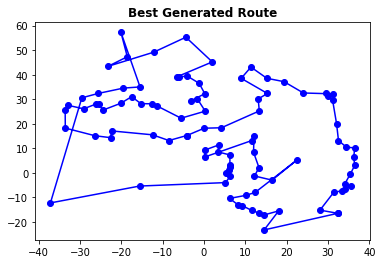

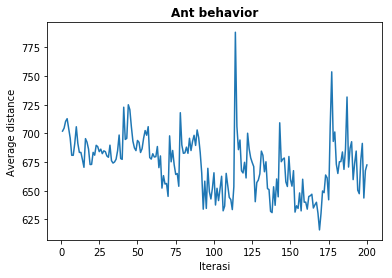

Running time so far:  4955.16 second
======================== END OF RUN:  27 ================================


=========================== RUN:  28 ====================================
Route     :  [1, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 64, 65, 66, 67, 63, 62, 61, 60, 59, 58, 57, 53, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 75, 76, 77, 87, 91, 92, 93, 95, 94, 23, 22, 24, 47, 46, 45, 49, 48, 42, 41, 40, 39, 38, 37, 34, 33, 32, 43, 44, 10, 28, 29, 30, 31, 35, 36, 78, 79, 50, 54, 51, 52, 2, 0, 1]
Best Route:  576.163990653


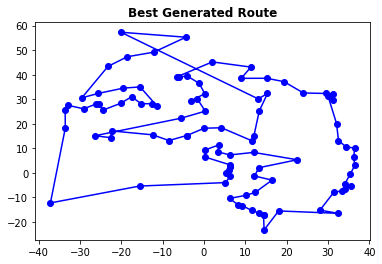

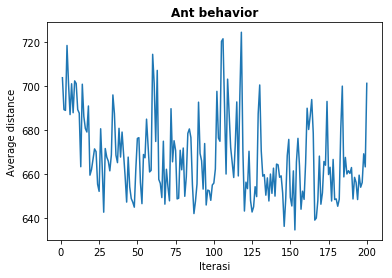

Running time so far:  5138.57 second
======================== END OF RUN:  28 ================================


=========================== RUN:  29 ====================================
Route     :  [45, 46, 47, 53, 57, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 76, 75, 91, 92, 93, 95, 64, 65, 66, 67, 63, 62, 61, 60, 59, 58, 70, 71, 72, 77, 87, 94, 27, 26, 25, 21, 22, 23, 24, 20, 18, 17, 16, 19, 15, 14, 13, 12, 11, 9, 8, 6, 7, 5, 4, 3, 2, 1, 28, 29, 30, 31, 35, 36, 37, 34, 33, 32, 43, 44, 10, 49, 51, 52, 54, 50, 48, 42, 41, 40, 39, 38, 78, 79, 0, 45]
Best Route:  577.388388452


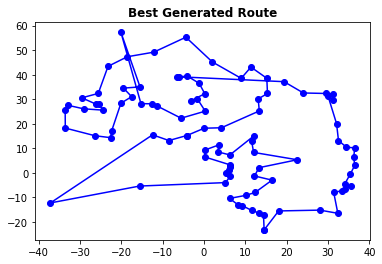

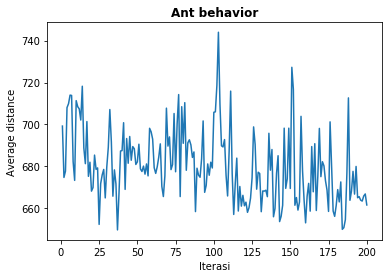

Running time so far:  5321.74 second
======================== END OF RUN:  29 ================================


=========================== RUN:  30 ====================================
Route     :  [79, 78, 38, 39, 40, 41, 42, 48, 49, 51, 52, 54, 50, 55, 56, 68, 69, 81, 80, 82, 90, 89, 88, 86, 85, 84, 83, 73, 74, 72, 71, 70, 75, 76, 77, 87, 91, 92, 93, 94, 95, 64, 65, 66, 67, 63, 62, 61, 60, 59, 58, 57, 53, 47, 46, 45, 44, 43, 32, 33, 34, 37, 36, 35, 31, 30, 29, 28, 1, 2, 3, 4, 5, 7, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 18, 17, 20, 21, 25, 27, 26, 22, 23, 24, 10, 0, 79]
Best Route:  553.931744682


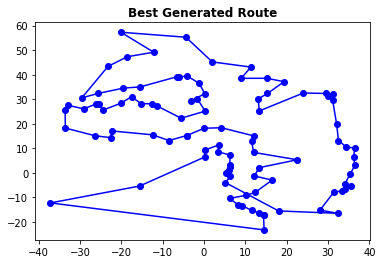

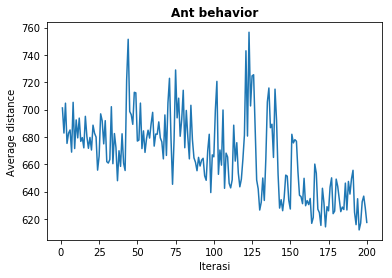

Running time so far:  5504.95 second
======================== END OF RUN:  30 ================================


532.341257057
560.622111555
538.987614631
558.61680267
559.424889966
583.13971552
554.839922411
546.650375005
560.501405677
581.219681919
564.95909181
567.566885062
559.795411408
543.363325587
552.319729742
581.161452947
551.298953542
566.205142599
558.61680267
560.482811049
558.61680267
543.363325587
551.076889071
567.943284475
557.268246667
558.781726069
558.636824838
576.163990653
577.388388452
553.931744682


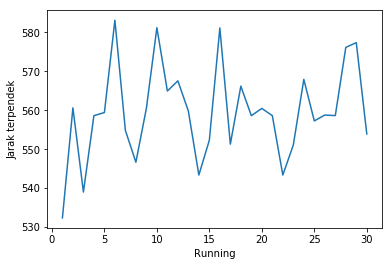

Rata-rata rute terpendek yang dihasilkan:  559.509486866
Total running time                      :  5505.04 second


In [14]:
if __name__ == '__main__':    
    running = 30
    global_distance = []
    start_time = time.clock()
    for run in range (running):
        print ("=========================== RUN: ",run+1,"====================================")
        iterasi = 200
        alpha = 11 #jejak pheromon
        beta = 14#visibility
        individu = 50
        n_kota = 96
        evaporation_coeff = 0.8
        Q = 0.2
        nodelist = []

        file = open ("Swarm096.tsp",'r')
        file.readline().strip().split()[1]
        for i in range (0,n_kota):
            no, x,y = file.readline().strip().split()
            nodelist.append([int(no),float(x),float(y)])

        matriks_jarak = generate_matriks_jarak(nodelist)
        tau = np.ones(np.shape(matriks_jarak))*0.0001 #init. intensitas pheromon/jejak pada busur
        delta_tau = np.zeros((n_kota,n_kota))

        shortest_distance = math.inf #infinit

        shortest_route = []
        average = []
        for i in range (iterasi):
            tabulists = generate_start_nodes(individu,n_kota)
            for j in range (1,n_kota):
                for k in range (individu):
                    tabulists[k][j] = evaluate_best_city(tabulists[k][j-1],matriks_jarak,tau, tabulists[k],alpha,beta)
            min_dist,route,L,rerata = compute_shortest_distances(tabulists,matriks_jarak)
            average.append(rerata)

            if shortest_distance > min_dist :
                shortest_distance = min_dist
                shortest_route = route
                
            tau = update_tau(individu, tau, tabulists, L, evaporation_coeff, Q,n_kota)

        print ("Route     : ",route)
        print ("Best Route: ",shortest_distance)
        global_distance.append(shortest_distance)
        plotNodes(nodelist,shortest_route)
        
        plt.plot([i for i in range (1,iterasi+1)],average)
        plt.title("Ant behavior",loc='center',fontweight='bold')
        plt.xlabel("Iterasi")
        plt.ylabel("Average distance")
        plt.show()
        
        print ("Running time so far: ","%.2f" %(time.clock() - start_time),"second")
        print ("======================== END OF RUN: ",run+1,"================================")
        print ()
        print ()
        
    for shortest in global_distance:
        print (shortest)   

    plt.plot([i for i in range (1,running+1)],global_distance)
    plt.xlabel("Running")
    plt.ylabel("Jarak terpendek")
    plt.show()
    print ("Rata-rata rute terpendek yang dihasilkan: ",np.average(global_distance))
    print ("Total running time                      : ","%.2f" %(time.clock() - start_time),"second")